# Transfer learning 

## Model training on a dataset

#### importing dataset from huggingface

In [14]:
from datasets import load_dataset
dataset = load_dataset('jojogo9/freshness_of_fruits_and_veges_256')


In [15]:
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5576
    })
})


#### preprocessing

In [16]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [17]:
from torch.utils.data import Dataset
from collections import Counter
import matplotlib.pyplot as plt
class HuggingFaceDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['label']
        if self.transform:
            image = self.transform(image)
        return image, label
    def get_labels(self):
        return [sample['label'] for sample in self.dataset]
    
    def show_sample(self, idx):
        image, label = self[idx]  # Get image and label
        plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(f"Label: {label}")
        plt.axis("off")
        plt.show()

#### train - test split

In [18]:
from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(range(len(dataset['train'])), test_size=0.2, random_state=42)
train_dataset = HuggingFaceDataset(dataset['train'].select(train_indices), transform=transform)
val_dataset = HuggingFaceDataset(dataset['train'].select(val_indices), transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.465708].


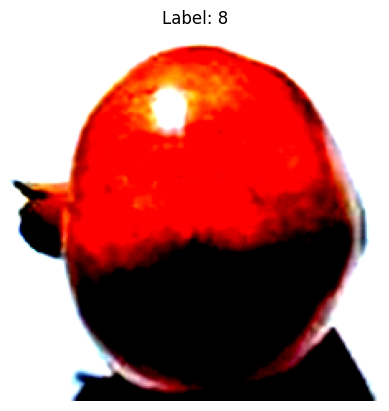

In [19]:
train_dataset.show_sample(7) 

In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


#### Modifying the last fully connected layer of resnet 18

In [21]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet18(weights=True)
num_ftrs = model.fc.in_features
num_classes = 24  # Adjust based on your dataset
model.fc = nn.Linear(num_ftrs, num_classes)


/Users/aryaman.sharma/transfer learning/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#### Training

In [ ]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Update tqdm with the current loss
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


In [15]:
torch.save(model.state_dict(), "resnet18_fruit_freshness.pth")
print("Model saved successfully!")


Model saved successfully!


In [25]:
import torch
import torchvision.models as models

# 1. Define the same model architecture
model = models.resnet18(pretrained=False)  # Ensure it matches the saved model
num_classes = 3  # Set this to your dataset's number of classes
model.fc = torch.nn.Linear(model.fc.in_features, 24)  # Adjust last layer

# 2. Load the saved state_dict
model.load_state_dict(torch.load("resnet18_fruit_freshness.pth"))

# 3. Move to the correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


/Users/aryaman.sharma/transfer learning/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aryaman.sharma/transfer learning/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Validating: 100%|██████████| 35/35 [00:37<00:00,  1.06s/batch]


Validation Accuracy: 0.9238
Precision: 0.9353
Recall: 0.9238
F1-score: 0.9242

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94        44
           1       1.00      0.94      0.97        47
           2       0.95      0.92      0.93        61
           3       1.00      0.89      0.94        44
           4       1.00      1.00      1.00        40
           5       1.00      0.68      0.81        41
           6       0.98      0.85      0.91        73
           7       0.95      1.00      0.97        37
           8       0.89      0.97      0.93        34
           9       0.96      0.81      0.88        54
          10       0.94      1.00      0.97        44
          11       1.00      1.00      1.00        54
          12       0.76      0.97      0.85        36
          13       0.90      1.00      0.95        38
          14       0.94      0.72      0.82        40
          15       0.95      0.9

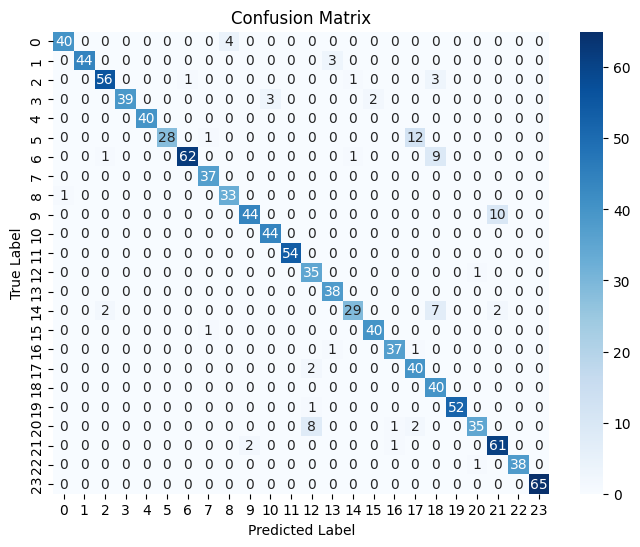

In [26]:

from tqdm import tqdm
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
device='cpu'
# Initialize variables
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Validating", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get predicted class indices

        # Store labels and predictions
        all_labels.extend(labels.cpu().numpy())  # Convert to NumPy array
        all_preds.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute accuracy
val_accuracy = correct / total
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Convert lists to NumPy arrays for sklearn metrics
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute precision, recall, and F1-score
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Display full classification report
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(all_labels), yticklabels=set(all_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


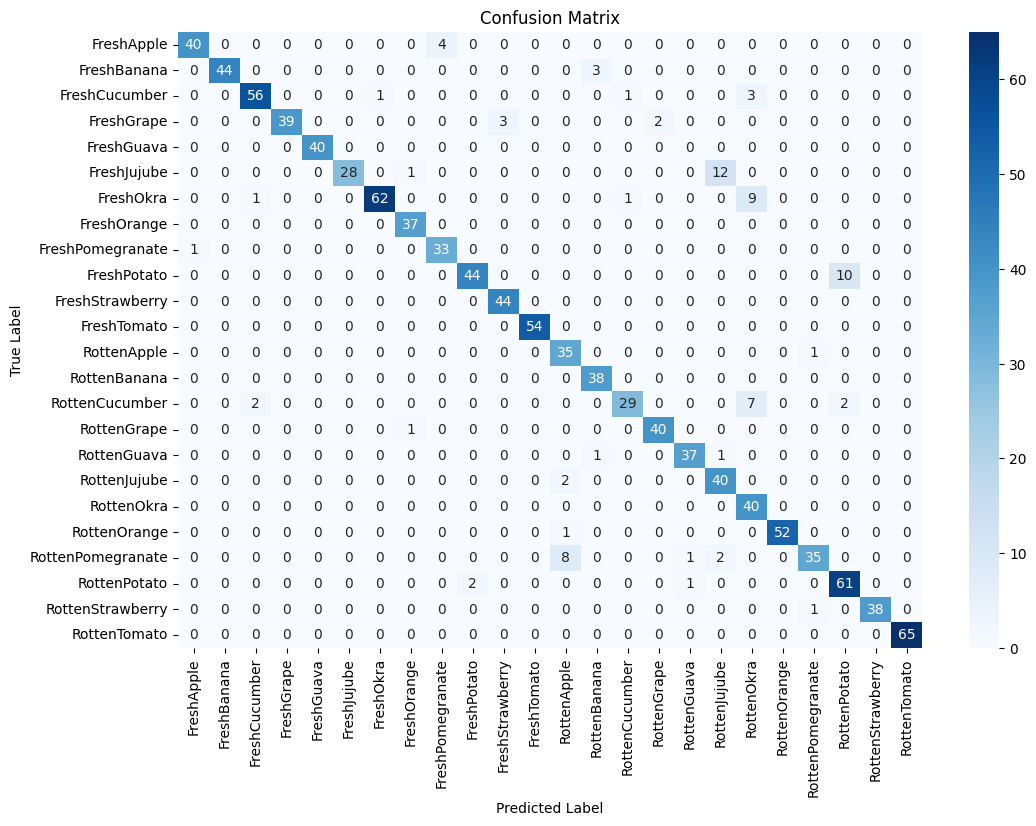

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert predictions and labels to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Define class labels (from your dataset)
class_labels = [
    'FreshApple', 'FreshBanana', 'FreshCucumber', 'FreshGrape', 'FreshGuava', 'FreshJujube', 'FreshOkra', 'FreshOrange', 
    'FreshPomegranate', 'FreshPotato', 'FreshStrawberry', 'FreshTomato', 'RottenApple', 'RottenBanana', 'RottenCucumber', 
    'RottenGrape', 'RottenGuava', 'RottenJujube', 'RottenOkra', 'RottenOrange', 'RottenPomegranate', 'RottenPotato', 
    'RottenStrawberry', 'RottenTomato'
]

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig("confusion_matrix.jpg", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
from tqdm import tqdm

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Validating", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = correct / total
print(f'Validation Accuracy: {val_accuracy:.4f}')


Validating: 100%|██████████| 35/35 [00:33<00:00,  1.03batch/s]

Validation Accuracy: 0.9238


# ONNX implementation


In [16]:
import torch

# Define dummy input (batch_size=1, 3 channels, 224x224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)


torch.onnx.export(
    model, 
    dummy_input, 
    "resnet18_fruit_freshness.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)
## dynamic size is important
print("ONNX model exported with dynamic batch size!")


print("Model converted to ONNX successfully!")


ONNX model exported with dynamic batch size!
Model converted to ONNX successfully!


### Comparison

#### ✅ Step 1: Measure Inference Speed in PyTorch

In [17]:
import torch
import time

# Set model to evaluation mode
model.eval()

# Dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up (to avoid initial slow CUDA launch times)
for _ in range(10):
    _ = model(dummy_input)

# Measure time
num_runs = 100  # Number of times to run inference
start_time = time.time()

with torch.no_grad():
    for _ in range(num_runs):
        _ = model(dummy_input)

end_time = time.time()

# Compute average time per inference
pytorch_time = (end_time - start_time) / num_runs
print(f"PyTorch Inference Time: {pytorch_time:.6f} seconds per run")


PyTorch Inference Time: 0.016834 seconds per run


#### ✅ Step 2: Measure Inference Speed in ONNX

In [18]:
import onnxruntime as ort
import numpy as np

# Load ONNX model
ort_session = ort.InferenceSession("resnet18_fruit_freshness.onnx")

# Convert dummy input to NumPy (ONNX requires NumPy)
dummy_input_np = dummy_input.cpu().numpy()

# Warm-up
for _ in range(10):
    _ = ort_session.run(None, {"input": dummy_input_np})

# Measure time
start_time = time.time()

for _ in range(num_runs):
    _ = ort_session.run(None, {"input": dummy_input_np})

end_time = time.time()

# Compute average time per inference
onnx_time = (end_time - start_time) / num_runs
print(f"ONNX Inference Time: {onnx_time:.6f} seconds per run")

# Speedup factor
speedup = pytorch_time / onnx_time
print(f"ONNX Runtime is {speedup:.2f}x faster than PyTorch")


ONNX Inference Time: 0.012262 seconds per run
ONNX Runtime is 1.37x faster than PyTorch


### Comparison with the validation set

#### Measure PyTorch Inference Time on Validation Set

In [19]:
import torch
import time

model.eval()
correct = 0
total = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end_time = time.time()

# Compute accuracy and time per batch
pytorch_time = end_time - start_time
val_accuracy = correct / total

print(f"PyTorch Validation Accuracy: {val_accuracy:.4f}")
print(f"PyTorch Total Inference Time: {pytorch_time:.4f} seconds")
print(f"PyTorch Average Time per Batch: {pytorch_time / len(val_loader):.6f} seconds")


PyTorch Validation Accuracy: 0.9238
PyTorch Total Inference Time: 33.6862 seconds
PyTorch Average Time per Batch: 0.962463 seconds


#### Measure ONNX Inference Time on Validation Set

In [20]:
import onnxruntime as ort
import numpy as np
import time

# Load ONNX model
ort_session = ort.InferenceSession("resnet18_fruit_freshness.onnx")

correct = 0
total = 0

start_time = time.time()

for inputs, labels in val_loader:
    inputs_np = inputs.numpy()  # Convert PyTorch tensor to NumPy
    outputs = ort_session.run(None, {"input": inputs_np})
    outputs = torch.tensor(outputs[0])  # Convert ONNX output back to PyTorch tensor
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

end_time = time.time()

# Compute accuracy and time per batch
onnx_time = end_time - start_time
val_accuracy_onnx = correct / total

print(f"ONNX Validation Accuracy: {val_accuracy_onnx:.4f}")
print(f"ONNX Total Inference Time: {onnx_time:.4f} seconds")
print(f"ONNX Average Time per Batch: {onnx_time / len(val_loader):.6f} seconds")

# Speedup factor
speedup = pytorch_time / onnx_time
print(f"ONNX Runtime is {speedup:.2f}x faster than PyTorch")


ONNX Validation Accuracy: 0.9238
ONNX Total Inference Time: 14.9824 seconds
ONNX Average Time per Batch: 0.428069 seconds
ONNX Runtime is 2.25x faster than PyTorch


## Using ONNX to optimise for Apple GPU 

In [21]:
import onnxruntime as ort
import numpy as np

# Use Metal (MPS) backend for Apple Silicon
providers = ['CoreMLExecutionProvider']  # Metal Performance Shaders (Apple GPU)

# Load ONNX model with Metal GPU acceleration
ort_session = ort.InferenceSession("resnet18_fruit_freshness.onnx", providers=providers)

print("ONNX Model Loaded with CoreMLExecutionProvider")


ONNX Model Loaded with CoreMLExecutionProvider


## Comparing on the validation set again

In [22]:
import time
import torch
import numpy
def benchmark_onnx_inference(ort_session, inputs_np, num_runs=100):
    # Warm-up
    for _ in range(10):
        _ = ort_session.run(None, {"input": inputs_np})
    
    # Measure inference time
    start_time = time.time()
    for _ in range(num_runs):
        _ = ort_session.run(None, {"input": inputs_np})
    end_time = time.time()
    
    avg_time = (end_time - start_time) / num_runs
    print(f"ONNX Inference Time: {avg_time:.6f} seconds per run")
    return avg_time

# Convert a validation batch to NumPy
inputs_np = next(iter(val_loader))[0].numpy()

# Run on MPS (Apple GPU)
print("Running ONNX on M1/M2 GPU (Metal)...")
onnx_gpu_time = benchmark_onnx_inference(ort_session, inputs_np)

# Run on CPU for comparison
ort_session_cpu = ort.InferenceSession("resnet18_fruit_freshness.onnx", providers=['CPUExecutionProvider'])
print("Running ONNX on CPU...")
onnx_cpu_time = benchmark_onnx_inference(ort_session_cpu, inputs_np)

# Compare Speedup
speedup = onnx_cpu_time / onnx_gpu_time
print(f"🚀 ONNX on Apple GPU is {speedup:.2f}x faster than CPU!")


Running ONNX on M1/M2 GPU (Metal)...
ONNX Inference Time: 0.017636 seconds per run
Running ONNX on CPU...
ONNX Inference Time: 0.384750 seconds per run
🚀 ONNX on Apple GPU is 21.82x faster than CPU!
